## Setup

In [1]:
! pip install import_ipynb
import import_ipynb
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import torch

%matplotlib inline    

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=048a49a51c3f69114a97b8a8c747f3447d741a1ee1623562345c00321e23567b
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [2]:
# mount google drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/Colab Notebooks/flu_predictions/curr'
import flu_preprocessing as prep
%cd '/content/drive/'

/content/drive/My Drive/Colab Notebooks/flu_predictions/curr
importing Jupyter notebook from flu_preprocessing.ipynb


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/content/drive


In [4]:
# get data from google drive and read in as csv
train_features = pd.read_csv('/content/drive/My Drive/sideprojects/flu_predictions/training_set_features.csv')
train_labels = pd.read_csv('/content/drive/My Drive/sideprojects/flu_predictions/training_set_labels.csv')
test_features = pd.read_csv('/content/drive/My Drive/sideprojects/flu_predictions/test_set_features.csv')

## Preprocessing

In [5]:
# combine train_features and train_labels for preprocessing - drop extra respondent_id columns
train = pd.concat([train_features, train_labels.iloc[:,1:]], axis=1)

In [6]:
print('TRAINING DATA SUMMARY')
train.info()
print('TEST DATA SUMMARY')
test_features.info()

TRAINING DATA SUMMARY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64

### Basic cleaning

In [7]:
# count null values 
prep.nullFinder(train, 'TRAINING')
prep.nullFinder(test_features, 'TEST')

# reorganize employment_industry, employment_occupation
# drop health insurance - half of its values are missing
prep.organize(train)
prep.organize(test_features)

,# missing values
respondent_id,0
h1n1_concern,92
h1n1_knowledge,116
behavioral_antiviral_meds,71
behavioral_avoidance,208
behavioral_face_mask,19
behavioral_wash_hands,42
behavioral_large_gatherings,87
behavioral_outside_home,82
behavioral_touch_face,128


,# missing values
respondent_id,0
h1n1_concern,85
h1n1_knowledge,122
behavioral_antiviral_meds,79
behavioral_avoidance,213
behavioral_face_mask,19
behavioral_wash_hands,40
behavioral_large_gatherings,72
behavioral_outside_home,82
behavioral_touch_face,128


In [8]:
# recheck the number of null values in employment_industry and employment_occupation - did manipulating these columns
# based on employment_status help? 

print('employment_industry nulls (TRAINING): {}'.format(
    len(train['employment_industry']) - train['employment_industry'].count()))
print('employment_occupation nulls (TRAINING): {}'.format(
    len(train['employment_industry']) - train['employment_industry'].count()))
print('employment_industry nulls (TEST): {}'.format(
    len(test_features['employment_industry']) - test_features['employment_industry'].count()))
print('employment_occupation nulls (TEST): {}'.format(
    len(test_features['employment_industry']) - test_features['employment_industry'].count()))

employment_industry nulls (TRAINING): 1646
employment_occupation nulls (TRAINING): 1646
employment_industry nulls (TEST): 1670
employment_occupation nulls (TEST): 1670


In [9]:
# drop duplicates, drop respondent_id because that won't help us classify this data
train.drop(['respondent_id'], axis=1, inplace=True)
test_features.drop(['respondent_id'], axis=1, inplace=True)

In [10]:
# drop rows with null values
train.dropna(inplace=True)
train.reset_index(inplace=True, drop=True)

test_features.dropna(inplace=True)
test_features.reset_index(inplace=True, drop=True)

### Column engineering

| feature | new level | new level | new level |
| ------- | ------ | ------ | ------| 
| h1n1_concern | [(0,1) to become] 0 = less concern <br> | [(2,3) to become] 1 = more concern<br> | NONE | 
| household_adults (will be renamed: live_alone) | [(1,2,3) to become] 0 = does not live alone | [(0) to become] 1 = lives alone | NONE | 
| household_children (will be renamed: have_children) | [(0) to become] 0 = no children | [(1,2,3) to become] 1 = children | NONE | 
| employment_status | [(['Not in Labor Force', 'Unemployed']) to become] 0 = not working | [(['Employed']) to become] 1 = working | NONE |
| education | [(['< 12 Years', '12 Years']) to become] 0 = high school or less | [(['Some College']) to become] 1 = some college | [(['College Graduate']) to become] 2 = college grad |
| opinion_h1n1_vacc_effective | [(1,2) to become] 0 = not effective | [(3) to become] 1 = don't know | [(4,5) to become] 2 = effective | 
| opinion_seas_vacc_effective | [(1,2) to become] 0 = not effective | [(3) to become] 1 = don't know | [(4,5) to become] 2 = effective | 
|opinion_h1n1_sick_from_vacc | DROP 3 (DON'T KNOW) - too small, creates noise | [(1,2) to become] 0 = not worried | [(4,5) to become] 1 = worried |
| opinion_seas_sick_from_vacc  | DROP 3 (DON'T KNOW) - too small, creates noise | [(1,2) to become] 0 = not worried | [(4,5) to become] 1 = worried |
| opinion_h1n1_risk | DROP 3 (DON'T KNOW) - too small, creates noise | [(1,2) to become] 0 = low | [(4,5) to become] 1 = high |
| opinion_seas_risk | DROP 3 (DON'T KNOW) - too small, creates noise | [(1,2) to become] 0 = low | [(4,5) to become] 1 = high |

In [11]:
# transforming columns based on the specifications above
train = prep.columnTransformer(train)
test_features = prep.columnTransformer(test_features)

### Encoding features
| Feature type | Feature description | Associated features | Action |
| ------------ | ------------------- | ------------------- | ------ |
| binary | 2 levels [0,1] - <br> described as no/yes, low/high, etc | - 'h1n1_concern' <br> - 'behavioral_avoidance' <br> - 'behavioral_wash_hands' <br> - 'behavioral_large_gatherings' <br>- 'behavioral_outside_home' <br> - 'behavioral_touch_face' <br> - 'doctor_hecc_h1n1' <br> - 'doctor_recc_seasonal' <br> - 'chronic_med_condition' <br> - 'health_worker' <br>- 'opinion_h1n1_risk' <br>- 'opinion_h1n1_sick_from_vacc' <br>- 'opinion_seas_risk' <br>- 'opinion_seas_sick_from_vacc' <br> - employment_status <br>- 'live_alone' <br> - 'have_children' <br>- 'education' <br> - 'behavioral_antiviral_meds' <br> - 'behavioral_face_mask' <br> - 'child_under_6_months' | No action - 2 levels each (0,1) |
| multiple | >2 levels [0,1,2,n...] | - 'opinion_h1n1_vacc_effective' <br>- 'opinion_seas_vacc_effective' <br> - 'h1n1_knowledge' | No action - 3 levels each | 
| text | levels are strings | - 'age_group' <br>- 'sex'<br>- 'income_poverty'<br>- 'rent_or_own'<br>- 'hhs_geo_region'<br>- 'census_msa'<br>- 'race'<br>- 'employment_industry'<br>- 'employment_occupation' <br>- marital_status | - census_msa and income_poverty to be manually ordinally encoded <br> - age_group to be ordinally encoded <br> - hhs_geo_region, race, employment_industry, employment_occupation <br>&nbsp; to be feature hash encoded OR binary encoded<br> - sex, marital_status, and rent_or_own to be one hot encoded (drop_first=True) | 


In [12]:
# drop duplicates
train.drop_duplicates(ignore_index=True, inplace=True)
test_features.drop_duplicates(ignore_index=True, inplace=True)

In [13]:
# split the features and labels again
train = train.reset_index(drop=True)

train_features = train.iloc[:,:-2]
train_labels = train.iloc[:,-2:]

test_features = test_features

h1n1_labels = train_labels['h1n1_vaccine']
szn_labels = train_labels['seasonal_vaccine']

In [14]:
train_features, test_features = prep.encoder(train_features, test_features, 'binary')

In [15]:
# turn all encoded features into pd.categorical type 
for t in list(train_features.columns):
  train_features[t] = pd.Categorical(train_features[t])
for t in list(test_features.columns):
  test_features[t] = pd.Categorical(test_features[t])

In [16]:
# change dataframes to float type 
train_features = pd.DataFrame(np.array(train_features, dtype=float), columns=train_features.columns)
test_features = pd.DataFrame(np.array(test_features, dtype=float), columns=test_features.columns)

## Feature selection

#### Feature selections using VIF (ie evaluating multicollinearity)

In [17]:
train_vif = prep.checkVIF(train_features)
multico_features = list(train_vif[train_vif['VIF Factor']>=10.0]['features'])

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [18]:
train_features = train_features.drop(multico_features, axis=1)
test_features = test_features.drop(multico_features, axis=1)

#### Feature selection using correlations


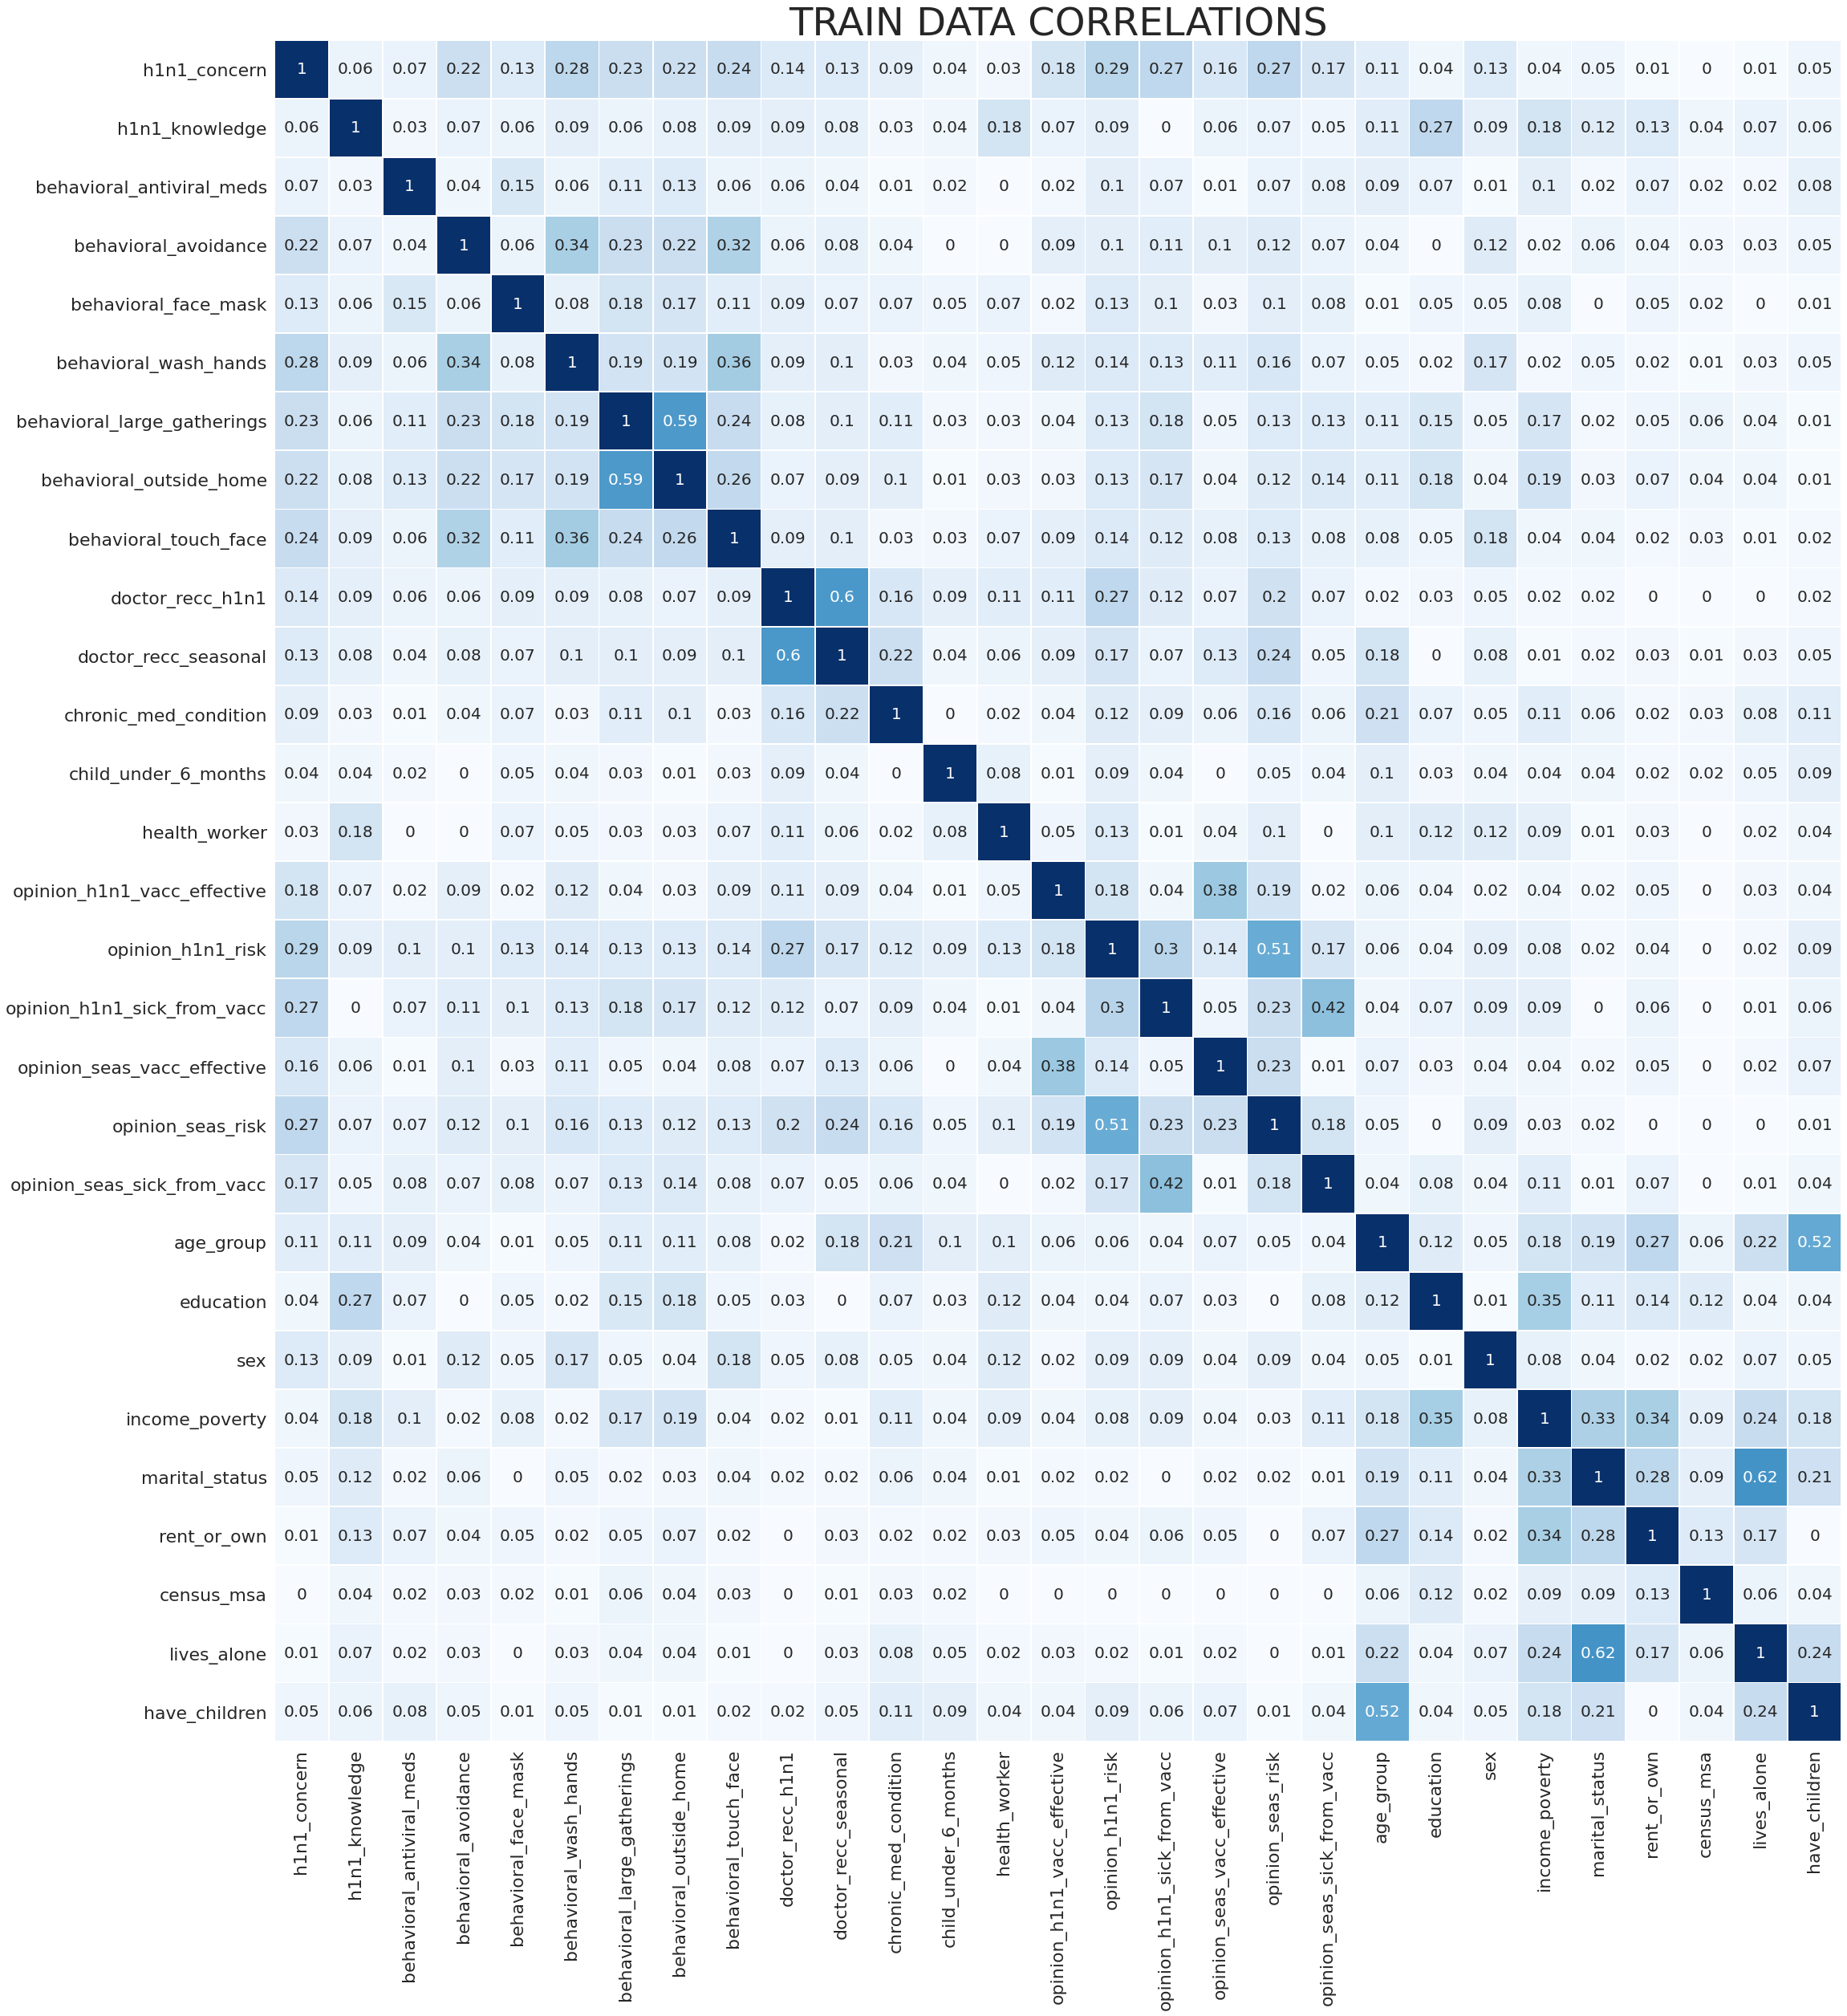

In [19]:
# get correlation matrix 
trainfCorrs = prep.cramersV(train_features)

# create correlation heatmap
prep.corrPlot(trainfCorrs, 'train data')

# correlation analysis
train_corrAnalysis, corr_drop = prep.corrAnalysis(trainfCorrs, 0.6)

In [20]:
train_corrAnalysis

,compared_feature1,compared_feature2,feature_to_drop,cramersV_for_featuretoDrop
0,marital_status,lives_alone,marital_status,0.62


In [21]:
# Drop the correlated columns we found above 
train_features = train_features.drop(corr_drop, axis=1)
test_features = test_features.drop(corr_drop, axis=1)

#### Feature importances (using Random Forest)

##### train test split

In [22]:
# make a copy of test_features because we will predict h1n1 and seasonal separately 
Xh_test = test_features.copy()
Xs_test = test_features.copy()

In [23]:
# train validation split
Xh_train, Xh_val, yh_train, yh_val = train_test_split(train_features, h1n1_labels, test_size=0.2, random_state=0)
Xs_train, Xs_val, ys_train, ys_val = train_test_split(train_features, szn_labels, test_size=0.2, random_state=0)

##### implementing random forest

In [24]:
# scale and balance 
Xh_train, yh_train = prep.scale(Xh_train, yh_train)
Xh_train, yh_train = prep.balance(Xh_train, yh_train)
Xh_val, yh_val = prep.scale(Xh_val, yh_val)
Xh_val, yh_val = prep.balance(Xh_val, yh_val)

Xs_train, ys_train = prep.scale(Xs_train, ys_train)
Xs_val, ys_val = prep.scale(Xs_val, ys_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [25]:
# create pipeline
rf_pipe = Pipeline([('classifier', RandomForestClassifier(random_state=0))])

# create search space - i will experiment with 2 search spaces 
rf_params1 = [{'classifier__max_depth': [10,20],
              'classifier__min_samples_split': [6,10], 
              'classifier__max_leaf_nodes': [75,150],  
              'classifier__n_estimators': [250,750],  
              'classifier__max_features': ['sqrt', 0.5, 1.0]}]
rf_params2 = [{'classifier__max_depth': [5,10,15,20,25],
              'classifier__min_samples_split': [4, 6, 8, 10, 12], 
              'classifier__max_leaf_nodes': [50, 100, 250, 500, 750],  
              'classifier__n_estimators': [100, 250, 500, 750],  
              'classifier__max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
              'classifier__bootstrap': [False, True],}]

In [26]:
# implement randomized search 
hrf_search = prep.randomSearch(est = rf_pipe, params = rf_params1, cv=4)
srf_search = prep.randomSearch(est = rf_pipe, params = rf_params1, cv=4)

In [27]:
# fit the searcher object 
hrf_search.fit(Xh_train, yh_train)
srf_search.fit(Xs_train, ys_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  8.3min finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.0min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('classifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     max_samples=None,
                                                                     min_impurity_decrease=0.0,
                                                       

In [28]:
# or, optionally load up an old model
# hrf_search = prep.modelLoad(F"/content/drive/My Drive/hrf_corrVIF_noimb.pt")
# srf_search = prep.modelLoad(F"/content/drive/My Drive/srf_corrVIF_noimb.pt")

In [29]:
# create and fit a random forest classifier using the best_params found in the randomized search above
hrf = prep.makeRFClassifier(hrf_search)
hrf.fit(Xh_train, yh_train)

srf = prep.makeRFClassifier(srf_search)
srf.fit(Xs_train, ys_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=150, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=750,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [30]:
# feature importances - create a function for this too and put it in prep
hrf_imp = prep.findFeatImps(hrf, Xh_train)
srf_imp = prep.findFeatImps(srf, Xs_train)

In [31]:
# generating a list of features that we want to keep based on their importance - tested using trial and error 
hrf_feats = list(hrf_imp[hrf_imp['importance']>=0.01].index)
srf_feats = list(srf_imp[srf_imp['importance']>=0.005].index)

In [32]:
# keep only important features 
Xh_train = Xh_train[hrf_feats]
Xh_val = Xh_val[hrf_feats]

Xs_train = Xs_train[srf_feats]
Xs_val = Xs_val[srf_feats]

## Prediction using LightGBM



In [33]:
from sklearn.metrics import roc_auc_score, fbeta_score

In [ ]:
import lightgbm as lgb
from bayes_opt import BayesianOptimization

In [38]:
# determining a baseline score 
h1n1_model = lgb.LGBMClassifier(objective='binary', random_state=0)
h1n1_scores = fit_score(h1n1_model, Xh_train, yh_train, Xh_val, yh_val)
print('The baseline ROC AUC score on Xh_val is {:.3f}.'.format(h1n1_scores[0]))
print('The baseline F1 score on Xh_val is {:.3f}.'.format(h1n1_scores[1]))
print('-------')

szn_model = lgb.LGBMClassifier(objective='binary', random_state=0)
szn_scores = fit_score(szn_model, Xs_train, ys_train, Xs_val, ys_val)
print('The baseline ROC AUC score on Xs_val is {:.3f}.'.format(szn_scores[0]))
print('The baseline F1 score on Xs_val is {:.3f}.'.format(szn_scores[1]))

The baseline ROC AUC score on Xh_val is 0.885.
The baseline F1 score on Xh_val is 0.880.


The baseline ROC AUC score on Xs_val is 0.771.
The baseline F1 score on Xs_val is 0.758.


In [ ]:
# bayesian optimization
h_best = bayes_parameter_opt_lgb(Xh_train, yh_train, is_unbalance=False)
s_best = bayes_parameter_opt_lgb(Xs_train, ys_train, is_unbalance=False)

h_best2 = bayes_parameter_opt_lgb(Xh_train, yh_train, is_unbalance=True)
s_best2 = bayes_parameter_opt_lgb(Xs_train, ys_train, is_unbalance=True)  

In [40]:
# h_best, etc --> is_unbalance = False
# h_best2, etc --> is_unbalance = True 

s_best

{'params': {'bagging_fraction': 0.7891062072884492,
  'feature_fraction': 0.29254811045314166,
  'lambda_l1': 0.3508761691449641,
  'lambda_l2': 0.7282692472538738,
  'learning_rate': 0.11358897024226143,
  'max_depth': 8.268835382636787,
  'min_child_weight': 7.09255752662831,
  'min_split_gain': 0.05280386144238312,
  'num_iterations': 990.8574496825604,
  'num_leaves': 24.566375592018844},
 'target': 0.8418674406178657}